# Preliminaries

## Load

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import sklearn as skl
import scipy as sp
import scipy.cluster.hierarchy
from sklearn import datasets

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from skimage import color
from colorsys import rgb_to_hsv

import sys
sys.path.append('/home/andy/Documents/Research/pnri/Helpers')
sys.path.append('/home/andy/Documents/Research/Minimax_Linkage/cpp_code/')

import importlib
pcl = importlib.import_module('protoclust')
cpcl = importlib.import_module('c_protoclust')
cplt = importlib.import_module('colonyplotting')

## Reload 

In [3]:
pcl = importlib.reload(pcl)
cpcl = importlib.reload(cpcl)
cplt = importlib.reload(cplt)

## Utilities

In [4]:
def labelXYZ(ax, xlabel, ylabel, zlabel=None, params={}):
    ax.set_xlabel(xlabel, **params)
    ax.set_ylabel(ylabel, **params)
    if zlabel:
        ax.set_zlabel(zlabel, **params)
    return ax

# https://joernhees.de/blog/
def fancy_dendrogram(ax, *args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = sp.cluster.hierarchy.dendrogram(*args, **kwargs)

    if kwargs.get('truncate_mode', False):
        trunc_where = 'p={}'.format(kwargs.get('p', None))
    
    if not kwargs.get('no_plot', False):
        ax.set_title('Hierarchical Clustering Dendrogram (truncated {})'.format(trunc_where))
        ax.set_xlabel('sample index or (cluster size)')
        ax.set_ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                ax.plot(x, y, 'o', c=c)
        if max_d:
            ax.axhline(y=max_d, c='k', ls='--')
    return ddata

# Example 1: Faces

In [5]:
faces = skl.datasets.fetch_olivetti_faces()
X = faces.data
n,d = X.shape # d = 64x64
Y = faces.target

U,S,Vt = np.linalg.svd(X - np.mean(X, axis=0))

n,d

(400, 4096)

## Inspect SVD

<IPython.core.display.Javascript object>


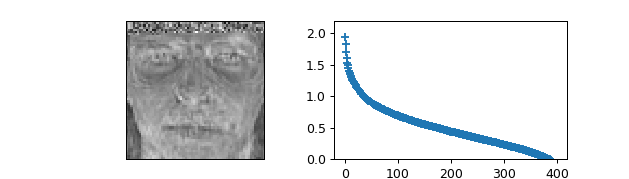

(0, 2.2)

In [34]:
fig, ax = plt.subplots(1,2, figsize=[7,2])
fig.subplots_adjust(wspace=0.1)

ax[0].imshow(Vt[:,0].reshape(64,64), cmap='gray')
cplt.clean_ax(ax[0])

ax[1].scatter(list(range(len(S))), np.log10(S), marker='+')
ax[1].set_ylim([0,2.2])

<IPython.core.display.Javascript object>


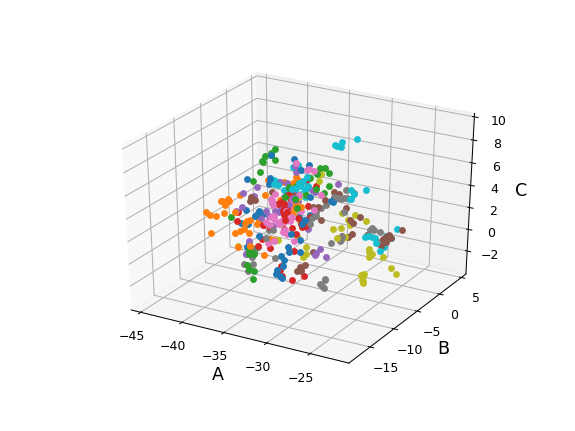

In [13]:
fig= plt.figure()
ax = fig.add_subplot(111, projection='3d')
pcX = X@Vt.T[:,:3]
colors, cnorm = [mpl.cm.get_cmap('tab10'), np.max(Y)]
for i,j,k,c in zip(pcX[:,0], pcX[:,1], pcX[:,2],Y):
    ax.scatter(i,j,k,color=colors(c/cnorm))
labelXYZ(ax, 'A','B','C', {'fontsize': 14});

## An example of protoclust

In [6]:
dm = pcl.distance_matrix(X, lambda x,y: np.sqrt(np.sum(np.square(x-y))))
dm = dm.asarray()

In [25]:
Z, clustering_data = cpcl.protoclust(dm, verbose=True, notebook=True)
clustering, clustering_centers, clustering_distances = [np.array(i) for i in clustering_data]

In [31]:
n

400

In [30]:
np.sort(np.array(Z)[:,:2].flat)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [26]:
Z[-1][2]

14.693964958190918

TODO: Consistent color schemes.

<IPython.core.display.Javascript object>


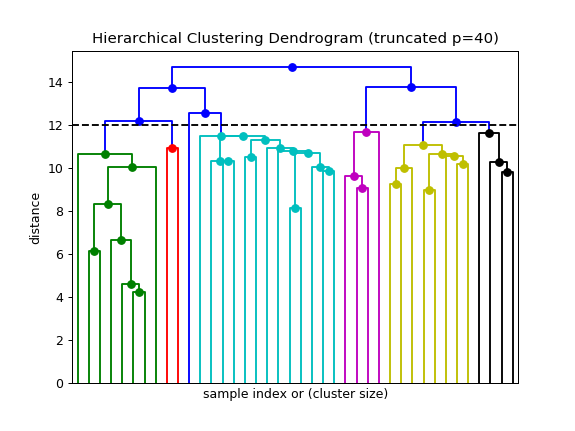

7


In [8]:
cut_height = 12

fig,ax  = plt.subplots(1)
fancy_dendrogram(ax, Z, p=40, truncate_mode='lastp', distance_sort=True, max_d=cut_height);
ax.set_xticks([])
T = sp.cluster.hierarchy.fcluster(Z, cut_height, criterion='distance')
indices,_ = sp.cluster.hierarchy.leaders(Z,T)
print(len(indices))
colors, cnorm = [mpl.cm.get_cmap('tab10'), len(indices)]

<IPython.core.display.Javascript object>


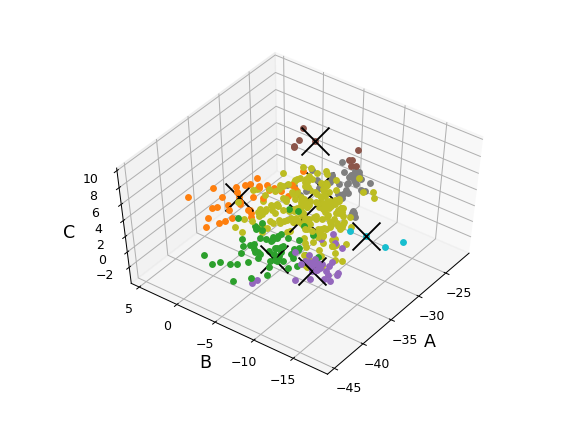

In [12]:
fig= plt.figure()
ax = fig.add_subplot(111, projection='3d')
pcX = X@Vt.T[:,:3]
for index, row in enumerate(pcX):
    c='gray'
    x1,x2,x3 = row
    ax.scatter(x1,x2,x3,color=colors(T[index]/cnorm))

for center in clustering_centers[indices]:
    x1,x2,x3 = pcX[center,:3]
    ax.scatter(x1,x2,x3, color='k', s=500, marker='x')
             
labelXYZ(ax, 'A','B','C', {'fontsize': 14});

<IPython.core.display.Javascript object>


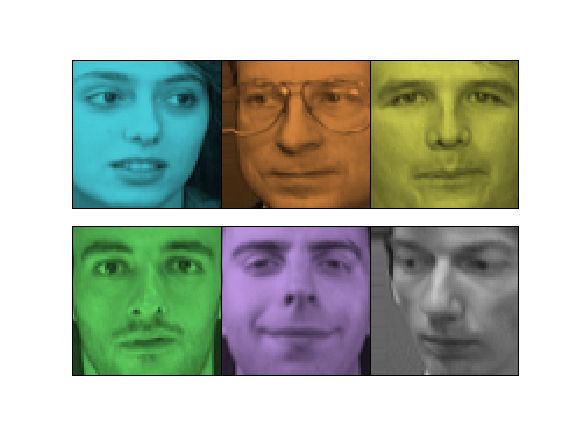

In [13]:
fig, ax = plt.subplots(2,3)
fig.subplots_adjust(wspace=0, hspace=0)
for i,row in enumerate(np.sort(clustering_centers[indices])):
    if len(ax.flatten()) == i:
        break
    im = X[row].reshape(64,64)
    im = color.gray2rgb(X[row].reshape(64,64))
    c_hsv = rgb_to_hsv(*colors(T[row]/cnorm)[:-1])
    im = cplt.colorize(im, c_hsv[0], .75*c_hsv[1])
    ax.flatten()[i].imshow(im, cmap='gray')
[cplt.clean_ax(iax) for iax in ax.flat];

# Example 2: Words

In [170]:
from scipy.io import loadmat

In [173]:
words = loadmat('Playground/grolier15276.mat')
X = words['grolier'].toarray()
n,d = X.shape

In [174]:
n,d

(15276, 30991)

In [175]:
def pairwise_dissimilarity(x,y):
    return 1 - np.sum(x*y)/(np.linalg.norm(x)*np.linalg.norm(y))

In [ ]:
# Too slow to run in python, unfortunately.
dm = pcl.distance_matrix(X, pairwise_dissimilarity)
dm = dm.asarray()

In [151]:
Z, clustering_data = pcl.protoclust(dm)
clustering, clustering_centers, clustering_distances = [np.array(i) for i in clustering_data]